In [1]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import SALib as sa
from SALib.sample import saltelli
from SALib.analyze import sobol
import shap


2023-11-23 08:25:37.676185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('4Mrows.csv', index=False)


In [5]:
data = pd.read_csv('../raw_data/4Mrows.csv')


In [6]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

# Start from scratch with data 

## Running preprocessor

In [7]:
processed_data = preprocess(data, ['OriginCty', 'DestinationCty'], as_ratio=True)
processed_data


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,PricePerPax,ItineraryRedirects,ODRedirects,redirect_ratio,OD,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio
0,NaN,NaN,NaN,BEG,BEG,RS,24,NaN,False,1,...,591.8100,1,2,0.500000,NaN,575.0,95.0,0.141791,7265.0,NaN
1,NaN,NaN,NaN,BEG,BEG,RS,24,NaN,False,1,...,637.9000,1,2,0.500000,NaN,585.0,145.0,0.198630,7244.0,NaN
2,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,180.1100,1,4,0.250000,NaN,115.0,0.0,0.000000,900.0,NaN
3,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,181.1900,1,4,0.250000,NaN,110.0,0.0,0.000000,900.0,NaN
4,NaN,NaN,NaN,BEY,BEY,LB,23,NaN,False,0,...,187.1000,1,4,0.250000,NaN,145.0,0.0,0.000000,1239.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580499,ZUH,ZUH,CN,KMG,KMG,CN,5,1133.0,False,0,...,125.2675,4,5,0.800000,ZUHKMG,120.0,0.0,0.000000,1133.0,1.000000
2580500,ZUH,ZUH,CN,KOW,KOW,CN,21,461.0,False,0,...,52.1950,1,1,1.000000,ZUHKOW,80.0,0.0,0.000000,461.0,1.000000
2580501,ZYL,ZYL,BD,MAN,MAN,GB,7,8070.0,False,0,...,716.5630,5,5,1.000000,ZYLMAN,690.0,0.0,0.000000,8070.0,1.000000
2580502,ZYL,ZYL,BD,MAN,MAN,GB,17,8070.0,True,3,...,887.4400,1,3,0.333333,ZYLMAN,860.0,495.0,0.365314,9428.0,1.168278


### Checking the distribution of the redirect ratio


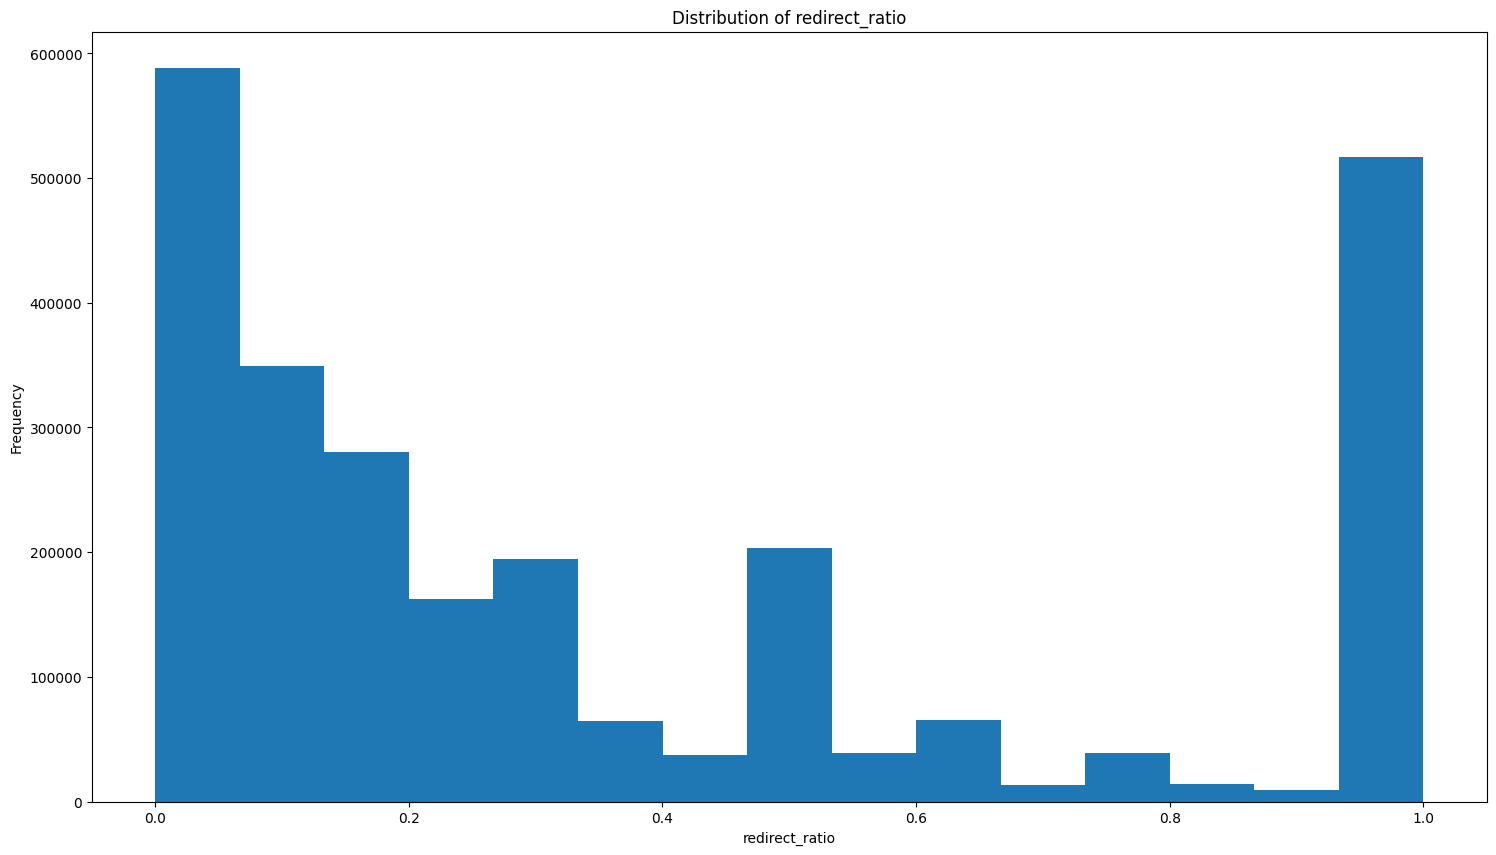

In [8]:
plt.figure(figsize=(18, 10))
plt.hist(processed_data["redirect_ratio"], bins=15)
plt.xlabel("redirect_ratio")
plt.ylabel("Frequency")
plt.title("Distribution of redirect_ratio")
plt.show()


In [ ]:
df_grouped = processed_data.groupby(["OriginCty", "OriginApt"]).count()
df_grouped


## Testing the binary encoder

In [ ]:
# import category_encoders as ce
# # Initialize BinaryEncoder
# binary_encoder = ce.BinaryEncoder(cols=["OD"])
# # Fit and transform the data
# binary_encoded_data = binary_encoder.fit_transform(processed_data)
# # Print the result
# print("Binary Encoded data:")
# print(binary_encoded_data.columns)


In [ ]:
model_columns = ['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio']

model_data = processed_data[model_columns]


In [ ]:
model_data.loc[:, "SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [ ]:
model_data.head()


In [ ]:
model_data.dtypes


In [ ]:
corr_matrix = model_data.corr()
corr_matrix


In [ ]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Set a larger figure size for readability
plt.figure(figsize=(10, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist()
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of ODRedirect
- Log of TravelDistanceKm
- Log of redirect_ratio
- Log of total_layover_time
- Log of extra_travel_distance

In [ ]:
model_data.head()


In [ ]:
model_data.dropna(inplace=True)


In [ ]:
model_data.isna().any().any()


In [ ]:
model_data.loc[:, 'ODRedirects'] = np.log1p(model_data['ODRedirects']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'TravelDistanceKm'] = np.log1p(model_data['TravelDistanceKm']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'redirect_ratio'] = np.log1p(model_data['redirect_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'total_layover_time_ratio'] = np.log1p(model_data['total_layover_time_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'extra_travel_distance_ratio'] = np.log1p(model_data['extra_travel_distance_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values


### Apply MinMax Scalar

In [ ]:
scaler = MinMaxScaler()


In [ ]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'redirect_ratio')


In [ ]:
Test_ODRedirect = X_test["ODRedirects"]
Test_ODRedirect


In [ ]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
model = Sequential()
model.add(layers.Dense(64, input_dim=7, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [ ]:
model.summary()


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)


In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [ ]:
# model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping], validation_split=0.2)


In [ ]:
#model.save('my_model.h5')


In [ ]:
model = load_model('../models/my_model.h5')


In [ ]:
# # Evaluate the model on the test set
# test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# # Print the results
# print(f"Test Loss (MSE): {test_loss}")
# print(f"Test Error (MAE): {test_error}")


In [ ]:
y_pred = model.predict(X_test)


In [ ]:
X_test.shape


In [ ]:
y_pred.shape


In [ ]:
y_pred.dtype


In [ ]:
y_test.shape


In [ ]:
y_test.dtypes


In [ ]:
y_diff = y_pred.flatten() - y_test


In [ ]:
y_diff_abs = y_diff.abs()


In [ ]:
y_diff.shape


In [ ]:
Test_ODRedirect


In [ ]:
Test_ODRedirect = np.expm1(Test_ODRedirect)
Test_ODRedirect


In [ ]:
plt.figure(figsize=(25, 18))
plt.scatter(Test_ODRedirect, y_diff, color='blue', alpha=0.1)
plt.title('Difference in Predictions vs ODRedirects')
plt.xlabel('ODRedirects')
plt.ylabel('Prediction Difference (y_pred - y_test)')
plt.grid(True)


In [ ]:
plt.figure(figsize=(25, 18))
plt.scatter(Test_ODRedirect, y_diff_abs, color='blue', alpha=0.1)
plt.title('Difference in Predictions vs ODRedirects')
plt.xlabel('ODRedirects')
plt.ylabel('Abs. Prediction Difference (y_pred - y_test)')
plt.grid(True)


In [ ]:
['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio']


# Define the model inputs
problem = {
    'num_vars': 7,
    'names': ['ODRedirects', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays', 'SelfTransfer', 'total_layover_time_ratio', 'extra_travel_distance_ratio'],  # Replace with your variables
    'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]  # Replace with your variable bounds
}

# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model
Y = np.array([model.predict(params.reshape(1, -1)) for params in param_values])

# Flatten Y if necessary
Y = Y.flatten()

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

# Si contains the sensitivity indices


In [ ]:
# Extracting the first order sensitivity indices
s1 = Si['S1']

# Creating a heatmap
plt.figure(figsize=(35, 15))
sns.heatmap([s1], annot=True, cmap='viridis', yticklabels=['S1'])
plt.title('First Order Sensitivity Indices')
plt.xticks(ticks=np.arange(len(s1)) + 0.5, labels=problem['names'])
plt.show()


In [ ]:
# Create the explainer
explainer = shap.DeepExplainer(model, data=X_train)  # X_train is your training data


# Assuming shap_values are already calculated for X_test
shap_values = explainer.shap_values(X_test)

# Initialize JavaScript in Jupyter for SHAP plots
shap.initjs()

# Feature Importance Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP Value Plot (Bee Swarm)
shap.summary_plot(shap_values, X_test)


In [ ]:

# # Assuming `model` is your trained model and `X_train` is your training data
# explainer = shap.DeepExplainer(model, X_train)
# shap_values = explainer.shap_values(X_test)  # X_test is your test data

# # Calculate the mean absolute SHAP values for each feature
# shap_sum = np.abs(shap_values[0]).mean(axis=0)

# # Create a bar plot
# plt.bar(range(len(shap_sum)), shap_sum)
# plt.xlabel('Feature Index')
# plt.ylabel('Mean Abs SHAP Value')
# plt.title('Feature Importance')
# plt.show()
